In [ ]:
import pandas as pd

data = pd.read_csv('IMBD.csv')
columns = ['title', 'description', 'genre', 'stars']
relevant = data[columns].copy()

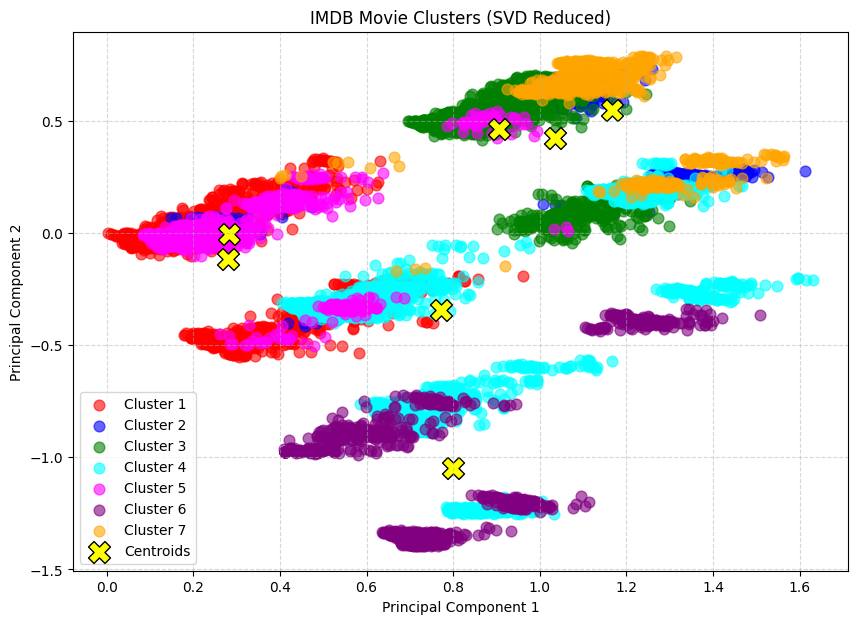

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix
import ast

genre_dummies = data['genre'].fillna('').str.get_dummies(sep=', ')
genre_sparse = csr_matrix(genre_dummies)

stars_clean = data['stars'].str.replace(r"[[\\]']", "", regex=True).fillna('')
tfidf_stars = TfidfVectorizer(max_features=500)
stars_sparse = tfidf_stars.fit_transform(stars_clean)

tfidf_title = TfidfVectorizer(max_features=500)
title_sparse = tfidf_title.fit_transform(data['title'].fillna(''))

tfidf_desc = TfidfVectorizer(max_features=1000)
desc_sparse = tfidf_desc.fit_transform(data['description'].fillna(''))
2
X_combined_sparse = hstack([genre_sparse, stars_sparse, title_sparse, desc_sparse])

from sklearn.metrics import silhouette_score


svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X_combined_sparse)

# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
#     labels = kmeans.fit_predict(X_reduced)
#     score = silhouette_score(X_reduced, labels)
#     print(f"For k={k}, Silhouette Score is {score}")

# best_kmeans = KMeans(n_clusters=7, n_init='auto', random_state=42)
# data['cluster'] = best_kmeans.fit_predict(X_reduced)

# print(data['cluster'].value_counts())

# for i in range(7):
#     print(f"\n--- Cluster {i} Sample Movies ---")
#     print(data[data['cluster'] == i]['title'].sample(min(5, len(data))).values)


# wcss = []
# for i in range(1, 11):
#     # n_init='auto' is more efficient in newer versions of sklearn
#     kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto', random_state=42)
#     kmeans.fit(X_reduced)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1, 11), wcss, marker='o')
# plt.title('The Elbow Method (Optimized with SVD)')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()


kmeans = KMeans(n_clusters=7, init='k-means++',  n_init=10)
y_kmeans = kmeans.fit_predict(X_reduced)

plt.figure(figsize=(10, 7))
colors = ['red', 'blue', 'green', 'cyan', 'magenta', 'purple', 'orange']

for i in range(7):
    plt.scatter(X_reduced[y_kmeans == i, 0],
                X_reduced[y_kmeans == i, 1],
                s=60, c=colors[i], label=f'Cluster {i+1}', alpha=0.6)

plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            s=250, c='yellow', marker='X', edgecolors='black', label='Centroids')

plt.title('IMDB Movie Clusters (SVD Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_precise_recommendations(movie_title, top_n=5):
    try:
        idx = data[data['title'].str.lower() == movie_title.lower()].index[0]
        target_cluster = data.loc[idx, 'cluster']
        target_vector = X_reduced[idx].reshape(1, -1)
    except IndexError:
        return "Movie not found."

    cluster_indices = data[data['cluster'] == target_cluster].index
    cluster_vectors = X_reduced[cluster_indices]

    similarities = cosine_similarity(target_vector, cluster_vectors).flatten()

    related_docs_indices = similarities.argsort()[-(top_n+1):-1][::-1]

    return data.iloc[cluster_indices[related_docs_indices]]['title'].values

print(get_precise_recommendations("Breaking Bad"))

['Breaking Bad' 'Bodies' 'Grenseland' 'Elite' 'Mai']


In [ ]:
from bs4 import BeautifulSoup
import requests

movie_title = input("Enter Movie Title: ").title()
API_KEY = '40aef168ab16c2f7c59380272ba1b17e'
BASE_URL = 'https://api.themoviedb.org/3'

def get_movie_details(movie_name):
    search_url = f"{BASE_URL}/search/movie"
    params = {
        'api_key': API_KEY,
        'query': movie_name
    }

    response = requests.get(search_url, params=params)
    results = response.json().get('results')

    if not results:
        return "No movie found."

    first_movie = results[0]
    movie_id = first_movie['id']

    detail_url = f"{BASE_URL}/movie/{movie_id}"
    detail_params = {'api_key': API_KEY}
    actual_url = f"https://www.themoviedb.org/movie/{movie_id}"

    movie_details = requests.get(detail_url, params=detail_params).json()
    website = requests.get(actual_url)
    soup = BeautifulSoup(website.text, 'html.parser')

    cast_cards = soup.find_all('li', class_='card')
    actors = [tag.get_text() for tag in cast_cards]
    actors_with_roles = [actor.strip() for actor in actors]
    actors_without_roles = [item.split('\n')[0] for item in actors_with_roles]

    keyword_cards = soup.find_all('section', class_='keywords right_column')
    keywords = [tag.get_text()[11:] for tag in keyword_cards]
    keywords_cleaned = [actor.strip().replace('\n', ', ') for actor in keywords]

    title = movie_details.get('title')
    tagline = movie_details.get('tagline')
    overview = movie_details.get('overview')
    genre_name = [genre['name'] for genre in movie_details['genres']]

    return {
        'title': title,
        'tagline': tagline,
        'overview': overview,
        'genre_names': genre_name,
        'actors': actors_without_roles,
        'keywords': keywords_cleaned,
    }

movie_info = get_movie_details(movie_title)

Enter Movie Title: shutter island


In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix, hstack

input_title = movie_info['title']
input_overview = movie_info['overview']
input_genre_names = movie_info['genre_names']
input_actors = movie_info['actors']

input_title_sparse = tfidf_title.transform([input_title])
input_desc_sparse = tfidf_desc.transform([input_overview or ""])

input_genre_str = ', '.join(input_genre_names)
temp_genre_df = pd.DataFrame({'genre_col': [input_genre_str]})
input_genre_encoded = temp_genre_df['genre_col'].str.get_dummies(sep=', ')

input_genre_aligned = input_genre_encoded.reindex(columns=genre_dummies.columns, fill_value=0)
input_genre_sparse = csr_matrix(input_genre_aligned.values)

input_actors_str = ' '.join(input_actors)
input_stars_sparse = tfidf_stars.transform([input_actors_str])

X_input_combined = hstack([input_genre_sparse, input_stars_sparse, input_title_sparse, input_desc_sparse])
X_input_reduced = svd.transform(X_input_combined)

y_pred_input = kmeans.predict(X_input_reduced)


relevant['cluster_labels'] = kmeans.labels_
target_cluster = y_pred_input[0]
recommendations = relevant[relevant['cluster_labels'] == target_cluster]
recommend_titles = recommendations['title'].tolist()

print(f"\n--- Recommendation Result ---")
print(f"Movie: {input_title}")
print(f"Assigned Cluster: {y_pred_input[0]}")
print(f"Because you liked '{input_title}', you might also like these movies from Cluster {target_cluster}:")
print(recommend_titles)


--- Recommendation Result ---
Movie: Shutter Island
Assigned Cluster: 0
Because you liked 'Shutter Island', you might also like these movies from Cluster 0:
['The Crown', 'Better Call Saul', 'Devil in Ohio', 'The Sandman', 'Breaking Bad', 'Blonde', 'Stranger Things', 'The Walking Dead', 'Glass Onion: A Knives Out Mystery', 'No Limit', '1899', 'Peaky Blinders', "Grey's Anatomy", 'Supernatural', 'American Horror Story', 'Ozark', 'Echoes', 'The Blacklist', 'Lucifer', 'Partner Track', 'Black Mirror', 'Outlander', 'Ófærð', 'Manifest', 'Locke & Key', 'Dark', 'The Vampire Diaries', 'Virgin River', 'Fargo', 'Animal Kingdom', 'Diario de un Gigoló', 'Heartbreak High', 'Blue Bloods', 'Loving Adults', 'American Psycho', 'Riverdale', 'Sons of Anarchy', 'Mad Men', 'Dahmer - Monster: The Jeffrey Dahmer Story', 'Mr. Robot', 'You', '365 Days', 'Titanic', 'Bridgerton', 'Sherlock', 'Dexter', 'The Expanse', 'Purple Hearts', 'The Good Doctor', 'Downton Abbey', 'Extraordinary Attorney Woo', 'Billions', 'Th

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

recs = list(set(recommend_titles))
data_list = []

for i in range(len(recs)):
  name = recs[i]
  idx = (data['title'] == name).idxmax()
  row_data = data.iloc[idx]
  row = {
        'Title': row_data['title'],
        'Genre': row_data['genre'],
        'Description': row_data['description'],
        'Stars': row_data['stars'],
    }
  data_list.append(row)

df = pd.DataFrame(data_list)

relevant_movie_info = {
        'Title': movie_info['title'],
        'Genre': movie_info['genre_names'],
        'Description': movie_info['overview'],
        'Stars': movie_info['actors'],
    }
df.loc[len(df)] = [movie_info['title'], ', '.join(movie_info['genre_names']), movie_info['overview'], str(movie_info['actors'])]
df = df.drop_duplicates(subset=['Title'], keep='first')

cv = CountVectorizer(max_features=len(df) - 1, stop_words='english')
vector = cv.fit_transform(df.astype(str).agg(' '.join, axis=1)).toarray()
similarity = cosine_similarity(vector)

movie_index = len(df) - 1

movie_similarities = list(enumerate(similarity[movie_index]))

distance = sorted(movie_similarities, reverse=True, key=lambda x: x[1])

for i in range(1, 11):
    similar_movie_idx = distance[i][0]
    similarity_score = distance[i][1]

    title = df.iloc[similar_movie_idx]['Title']
    print(f"{i}. {title} {similarity_score:.2f}")

1. Suite Française 0.39
2. Bottom of the World 0.32
3. Devil in Ohio 0.28
4. All the Light We Cannot See 0.27
5. Doctor Prisoner 0.26
6. Gone Girl 0.26
7. Black Book 0.25
8. The Guernsey Literary and Potato Peel Pie Society 0.25
9. Coroner 0.25
10. Leftenan Adnan 0.25
